In [ ]:
# !pip install pdpbox

In [133]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.optimizers import SGD, RMSprop, Adam
from keras.layers import Dense, Activation, Dropout
from sklearn.base import BaseEstimator, TransformerMixin
%matplotlib inline

from pdpbox import pdp, get_dataset, info_plots
%matplotlib inline

In [19]:
raw_train = pd.read_csv('./train_tit.csv', index_col=0)
raw_train['is_test'] = 0
raw_test = pd.read_csv('./test_tit.csv', index_col=0)
raw_test['is_test'] = 1

In [23]:
all_data = pd.concat((raw_train, raw_test), axis=0)

In [35]:
def get_title_last_name(name):
    full_name = name.str.split(', ', n=0, expand=True)
    last_name = full_name[0]
    titles = full_name[1].str.split('.', n=0, expand=True)
    titles = titles[0]
    return(titles)

def get_titles_from_names(df):
    df['Title'] = get_title_last_name(df['Name'])
    df = df.drop(['Name'], axis=1)
    return(df)

def get_dummy_cats(df):
    return(pd.get_dummies(df, columns=['Title', 'Pclass', 'Sex', 'Embarked',
                                       'Cabin', 'Cabin_letter']))

def get_cabin_letter(df):    
    df['Cabin'].fillna('Z', inplace=True)
    df['Cabin_letter'] = df['Cabin'].str[0]    
    return(df)

def process_data(df):
    # preprocess titles, cabin, embarked
    df = get_titles_from_names(df)    
    df['Embarked'].fillna('S', inplace=True)
    df = get_cabin_letter(df)
    
    # drop remaining features
    df = df.drop(['Ticket', 'Fare'], axis=1)
    
    # create dummies for categorial features
    df = get_dummy_cats(df)
    
    return(df)

proc_data = process_data(all_data)
proc_train = proc_data[proc_data['is_test'] == 0]
proc_test = proc_data[proc_data['is_test'] == 1]

In [94]:
# create model
model = Sequential()
model.add(Dense(input_dim=proc_data.shape[1]-2, units=512,
                 kernel_initializer='normal', bias_initializer='ones'))
model.add(Activation('relu'))

for i in range(0, 3):
    model.add(Dense(units=256, kernel_initializer='normal',
                     bias_initializer='zeros'))
    model.add(Activation('relu'))
    model.add(Dropout(.02))

model.add(Dense(units=1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-5))

In [95]:
# model.summary()

In [99]:
X = proc_train.drop(['Survived', 'is_test'], axis=1).fillna(-1)
y = proc_train.Survived.fillna(0)

In [100]:
model.fit(X,y,verbose=2,epochs=12)

Epoch 1/12
 - 0s - loss: 0.6304
Epoch 2/12
 - 0s - loss: 0.6256
Epoch 3/12
 - 0s - loss: 0.6254
Epoch 4/12
 - 0s - loss: 0.6172
Epoch 5/12
 - 0s - loss: 0.6132
Epoch 6/12
 - 0s - loss: 0.6095
Epoch 7/12
 - 0s - loss: 0.6072
Epoch 8/12
 - 0s - loss: 0.6022
Epoch 9/12
 - 0s - loss: 0.5983
Epoch 10/12
 - 0s - loss: 0.5937
Epoch 11/12
 - 0s - loss: 0.5828
Epoch 12/12
 - 0s - loss: 0.5812


In [109]:
pdp_age = pdp.pdp_isolate(
    model=model, dataset=X, model_features=X.columns, feature='Age'
)

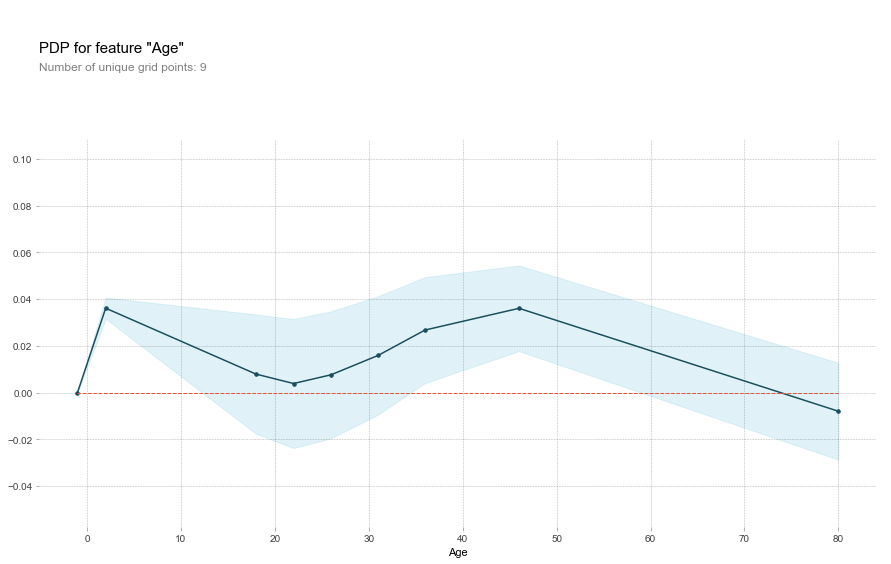

In [110]:
fig, axes = pdp.pdp_plot(pdp_age, 'Age')

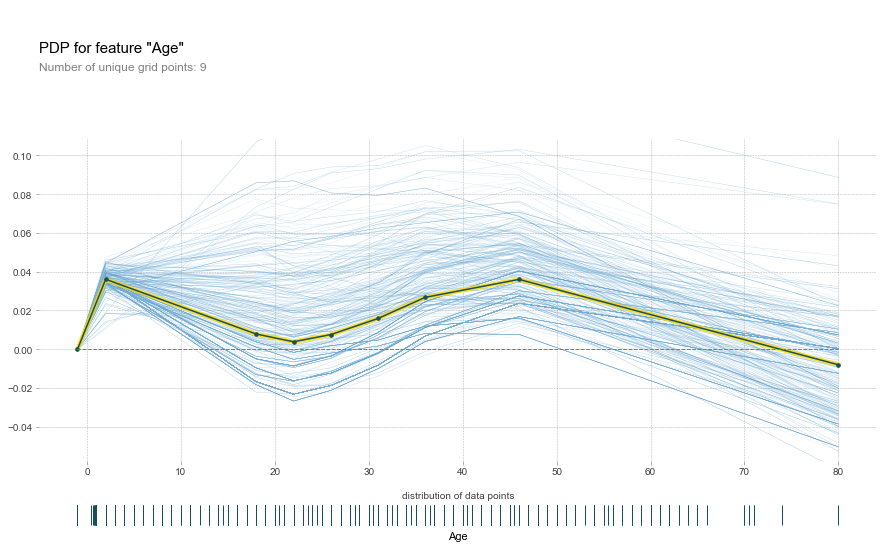

In [111]:
fig, axes = pdp.pdp_plot(pdp_age, 'Age', plot_lines=True, frac_to_plot=0.5, plot_pts_dist=True)




In [143]:
# Workaround 
class skl_model(BaseEstimator, TransformerMixin):
    def __init__(self,model):
        self.model=model
    def predict(self,X,par):
        return self.model.predict(X)

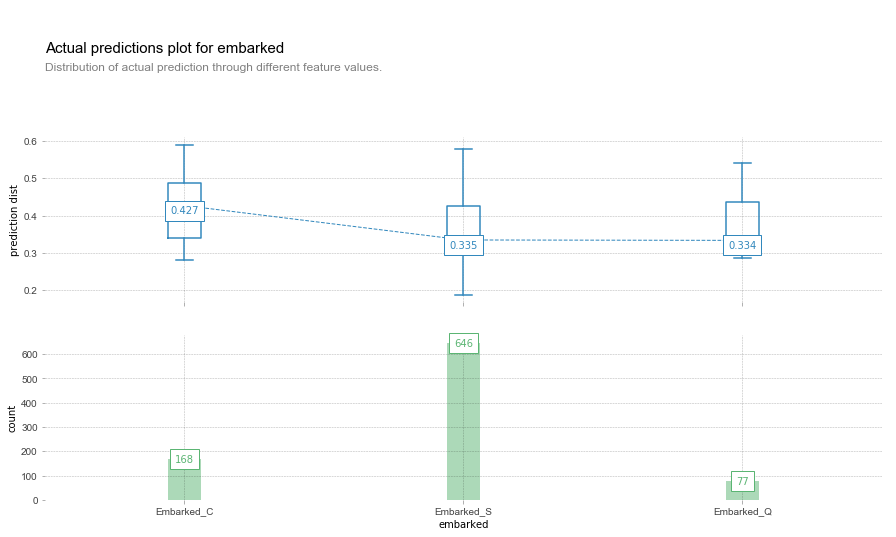

In [145]:
fig, axes, summary_df = info_plots.actual_plot(
    model=skl_model(model), X=X, feature=['Embarked_C', 'Embarked_S', 'Embarked_Q'],feature_name='embarked',
    predict_kwds={'par':1}
)


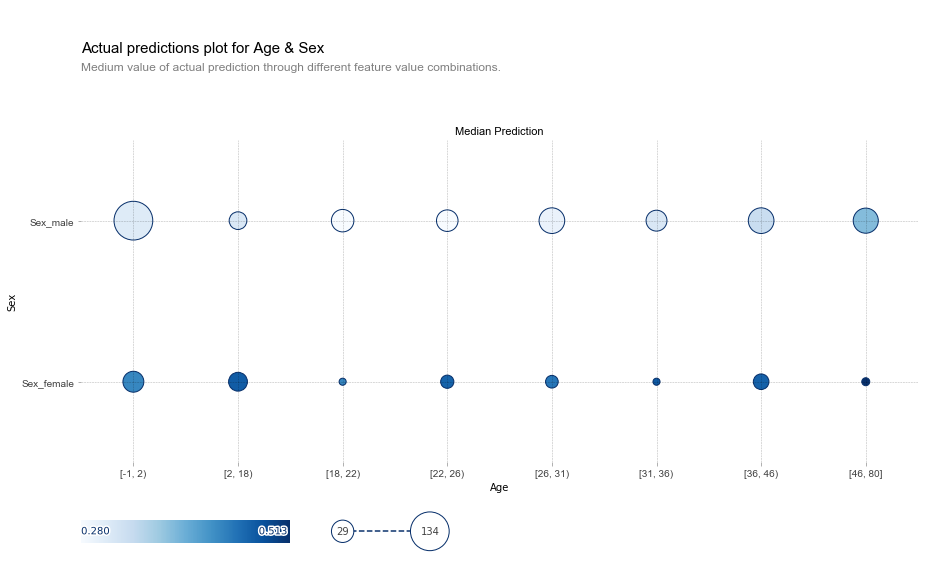

In [157]:
fig, axes, summary_df = info_plots.actual_plot_interact(
    model=skl_model(model), X=X, features=['Age', ['Sex_female','Sex_male']], feature_names=['Age', 'Sex'],
    predict_kwds={'par':1}
)